# MA6202: Laboratorio de Ciencia de Datos

**Profesor: Nicolás Caro**\
**Auxiliar: Rodrigo Lara M**

**12/07/2020 - Tarea 2**


**Integrantes del grupo**: Fabián Badilla M., Francisco Vásquez L., Javier Santibáñez M.

## Introducción

La siguiente evaluación corresponde a la segunda tarea del curso de laboratorio de ciencia de datos. A lo largo de la tarea se trabaja sobre un problema de clasificación binaria de imágenes torácicas de rayos X, buscando predecir si la imagen corresponde a neumonía.

Se evaluará la presentación de sus resultados por medio de un informe, las condiciones de entrega requeridas son:
* La extensión máxima del informe es de 8 planas a las que puede añadir 2 para anexos.
* Debe adjuntar un repositorio ``git`` donde se incluya todo su código.
    * A lo menos 1 ``commit`` por cada pregunta de la tarea
    * Por lo menos 1 ``merge`` a través de su trabajo.
* Incluya un documento ``jupyter notebook`` llamado ``tarea2.ipynb`` en el cual se exponga todo el procedimiento realizado.
* Por  ́ultimo es necesario también entregar un archivo *hdf* denominado ``modelo.h5`` que contenga los pesos del mejor modelo de red neuronal obtenido.

Tenga  en  mente  que  su  informe  será  revisado  por  un  equipo  técnico  que  debe  entender  a  cabalidad  su metodología, ser capaz de replicarlo y evaluarlo a partir de su lectura.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## P1. Carga y transformación de datos

Al abordar un problema de clasificación de imágenes con redes neuronales profundas, es importante optimizar el proceso de carga de datos. Al tratarse de imágenes, es de esperar que no todas las muestras puedan ser almacenadas en memoria de manera simultanea, por lo que es necesario construir un *generador*. El objetivo de la sección es construir un *generador* de muestras eficiente, que minimice el tiempo de carga de datos y optimice el uso de memoria.

El conjunto de datos a utilizar está disponible en este [link](https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip). En la Figura 1 se observan algunas muestras de cada clase. La carpeta ``train`` consta de alrededor de $5.000$ imágenes y la carpeta ``test``, cerca de $600$. Al ser un conjunto de datos pequeño, se emplean técnicas de aumentación de datos que serán detalladas a continuación.

1. Instancie objetos de la clase ``torchvision.datasets.DataFolder`` que le permitan cargar las imágenes de las carpetas ``train`` y ``test``. Además, Construya la función ``loader``, que permite cargar muestras de la base de datos. En el parámetro ``transform``, instancie un objeto de la clase ``torchvision.transforms.Compose`` que componga las siguientes transformaciones:
    * Escalamiento de la imagen a un tamaño de $224\times 224$ pixeles. Además escale los valores de brillo delos pixeles a valores entre $0$ y $1$, dividiendo por el valor máximo del tipo de dato ``uint8``
    * Con probabilidad $\frac{1}{2}$, voltee la imagen en el eje horizontal.
    * Rote la imagen, con respecto a su centro, con un ángulo aleatorio entre -$20°$ y $20°$.
    * Multiplique los valores de brillo de cada canal por un número aleatorio entre $1,2$ y $1,5$. Cada pixel debeser multiplicado por un número potencialmente distinto, es decir, a cada valor de brillo corresponde un número aleatorio potencialmente diferente.

In [2]:
from torchvision.datasets import DatasetFolder
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

os.chdir("./drive/My Drive/Tareas/Laboratorio de Ciencia de Datos/Tarea 2/")

In [3]:
def loader(input):
    '''Funcion que carga la imagen, si es de 1 canal las pasa a 3 canales '''
    image = Image.open(input)
    img = image.split()
    if len(img) == 1:
        return Image.merge('RGB', (img[0], img[0], img[0]))
    else:
        return image

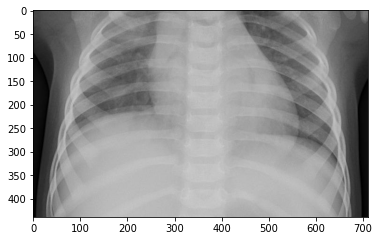

In [4]:
'''Ejemplo de carga de imagenes '''
img = loader('./data/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg')
# print(img.size)
plt.imshow(img)

In [5]:
'''Transformaciones necesarias '''

def ajust_brillo(img):
    '''Multiplica los valores de cada pixel por un número aleatorio entre 1.2 y 1.5 '''
    return img.point(lambda i: i*np.random.uniform(1.2,1.5))

transf = transforms.Compose([transforms.Resize([224, 224]),
                             transforms.ColorJitter(brightness=(0,1)), # dividiendo por el valor máximo... ??
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.RandomRotation(degrees=(-20,20)),
                             transforms.Lambda(lambda x: ajust_brillo(x))
                            ])

In [6]:
'''
Data debe estar en carpeta: data/chest_xray
Lo deje en gitignore porque pesa mucho y puede morir github
'''
data_train = DatasetFolder('./data/chest_xray/train', loader = loader, extensions=('jpeg'), transform=transf)
data_test = DatasetFolder('./data/chest_xray/test', loader = loader, extensions=('jpeg'), transform=transf)

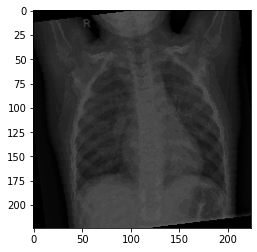

In [7]:
plt.imshow(data_train[0][0])#, cmap="gray")

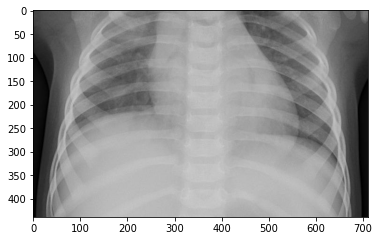

In [8]:
'''Ahora con OpenCV '''
import cv2 as cv

def loader_cv(input):
    return cv.imread(input)

img_cv = loader_cv('./data/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg')
plt.imshow(img_cv)

Mediante perfilamiento de tiempo de cómputo seleccione las herramientas que le parezcan óptimas para implementar las transformaciones anteriores. Puede utilizar las librerías ``pytorch``, ``PIL``, ``skimage`` u ``opencv``. Incluya en el reporte, una comparación con herramientas de 2 procesamientos de su elección.

**Observación:**  Se  recomienda  realizar  por  completo  las  secciones **P1** y **P2** antes de fundamentar su selección.

In [9]:
%timeit data_train[0][0]

10 loops, best of 3: 48.7 ms per loop


2. Visualice la cantidad de muestras de cada clase en las carpetas ``train`` y ``test``. Discuta sobre las implicancias de estas distribuciones.

In [10]:
def suma_clases(data):
    '''Dado un DatasetFolder, retorna cantidad de datos en clase 0 y 1 '''
    suma_c1 = sum(data.targets)
    suma_c0 = len(data.targets)-suma_c1
    return suma_c0, suma_c1

In [11]:
c0_train, c1_train = suma_clases(data_train)
c0_test, c1_test = suma_clases(data_test)

In [12]:
import pandas as pd

pd.DataFrame([[c0_train,c0_test],
              [c1_train,c1_test],
              [c0_train+c1_train,c0_test+c1_test]],
             columns=['Train','Test'],
             index=['Clase 0', 'Clase 1','Total'])

,Train,Test
Clase 0,1349,234
Clase 1,3883,390
Total,5232,624


Debido a que el balance de clases es diferente entre la carpeta ``train`` de la carpeta ``test``, es necesario definir cual es la distribución de clases del *problema*. En lo que sigue, asumiremos que dicha distribución es la que presenta la carpeta ``test``. Esto quiere decir que en un entorno de producción, se espera recibir muestras distribuidas de manera similar a tal conjunto, que llamaremos *conjunto de prueba*.

3. Separe los índices del objeto ``DataFolder`` de la carpeta ``train`` en un *conjunto de entrenamiento* y un *conjunto de validación*, con un $80$ y $20\%$ de las muestras respectivamente. Construya la clase ``ReplicarMuestreoDePrueba`` que herede de ``torch.utils.data.Sampler`` y permita iterar sobre el conjunto de validación de tal forma que replique la distribución de clases del *conjunto de prueba*, mediante un sobremuestreo de la clase minoritaria. Esta clase debe poseer los métodos:
    * ``__init__(self, etiquetas_prueba, indices_val, etiquetas_val):`` que guarde como atributos las variables necesarias para generar el muestreo deseado.
    * ``__iter__(self):`` que entregue un ``iterator`` sobre los índices del muestreo deseado
    
*Hint:* Puede ser útil emplear ``numpy.random.choice``. Observe que tendrá índices de validación duplicados.

**Observación:** Asuma que se trata de un problema de clasificación binaria.

In [14]:
from sklearn.model_selection import train_test_split

X_tr = np.array([np.asarray(obs[0]) for obs in data_train])
y_tr = np.array([obs[1] for obs in data_train])

X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size = .2)

In [15]:
print('X_train.shape: ', X_train.shape)
print('X_val.shape: ', X_val.shape)

X_train.shape:  (4185, 224, 224, 3)
X_val.shape:  (1047, 224, 224, 3)


In [16]:
from torch.utils.data import Sampler

class ReplicarMuestreoDePrueba(Sampler):
    '''
    Permite iterar sobre el conjunto de validación tal que replica la distribución
    de clases del conjunto de prueba, mediante un sobremuestreo de la clase minoritaria 
    '''
    def __init__(self, etiquetas_prueba, indices_val, etiquetas_val):
        self.etiquetas_prueba = etiquetas_prueba
        self.indices_val = indices_val
        self.etiquetas_val = etiquetas_val

    def __iter__(self):
        p_test = np.sum(self.etiquetas_prueba)/len(self.etiquetas_prueba) # prob de ser 1, en testeo
        if p_test < 0.5:
            p_vect = self.etiquetas_val 
        else:
            p_vect = 1 - self.etiquetas_val
        p_vect = p_vect/np.sum(p_vect) # debe sumar 1
        sampleo = self.indices_val
        sampleo_eti = self.etiquetas_val
        p_sampleo = np.sum(sampleo_eti)/len(sampleo_eti)
        while abs(p_sampleo - p_test) > 1e-3:
            index = np.random.choice(self.indices_val, size=1, p=p_vect)
            sampleo = np.append(sampleo, index)
            sampleo_eti = np.append(sampleo_eti, self.etiquetas_val[index])
            p_sampleo = np.sum(sampleo_eti)/len(sampleo_eti)
        return sampleo

In [17]:
X_test = np.array([np.asarray(obs[0]) for obs in data_test])
y_test = np.array([obs[1] for obs in data_test])

In [18]:
np.sum(y_test)/len(y_test)

0.625

In [19]:
'''Se comprueba que samplea distribucion similar a la de test '''
Sampleo = ReplicarMuestreoDePrueba(y_test, list(range(len(y_val))), y_val)
el_iter = Sampleo.__iter__()
np.sum(y_val[el_iter])/len(y_val[el_iter])

0.6256

4. Instancie objetos de la clase ``torch.utils.data.DataLoader`` para recorrer sus conjuntos de entrenamiento, validación y prueba. Para ello utilice los objetos adecuados en el parámetro ``sampler``. Discuta en el reporte las implicancias en tiempos de cómputo del parámetro ``num_workers``

*Hint:* Puede ser útil usar la clase ``torch.utils.data.sampler.SubsetRandomSampler`` para el *conjunto de entrenamiento* y ``torch.utils.data.RandomSampler`` para el *conjunto de prueba*.

**Observación:** Se recomienda realizar por completo las secciones **P1** y **P2** para fundamentar su discusión. Además, como referencia, en ``Colaboratory`` el parámetro ``batch_size=16`` es compatible con los recursos de la plataforma

In [20]:
from torch.utils.data import TensorDataset
import torch

train_ds = TensorDataset(torch.from_numpy(X_train).cuda(), torch.from_numpy(y_train).cuda())
valid_ds = TensorDataset(torch.from_numpy(X_val).cuda(), torch.from_numpy(y_val).cuda())
test_ds = TensorDataset(torch.from_numpy(X_test).cuda(), torch.from_numpy(y_test).cuda())
# test_ds = TensorDataset(data_test)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.sampler import SubsetRandomSampler

# faltan los parametros de los samplers
train_DL = DataLoader(train_ds, sampler = SubsetRandomSampler())
valid_DL = DataLoader(valid_ds, sampler = ReplicarMuestreoDePrueba(y_test, list(range(len(y_val))), y_val))
test_DL = DataLoader(test_ds, sampler = RandomSampler()) 

## P2. Redes convolucionales profundas

El objetivo de esta sección es construir una red neuronal profunda para el problema de clasificación de imágenes de rayos X sobre neumonía. Dicha red debe ser implementada en ``Pytorch``.

<img src="https://miro.medium.com/max/1400/1*yG6z6ESzsRW-9q5F_neOsg.png" alt="drawing" style="width:600px;" title="(a) Capa de convolución depthwise"/>
<img src="https://miro.medium.com/max/1400/1*Q7a20gyuunpJzXGnWayUDQ.png" alt="drawing" style="width:600px;" title="(b) Capa de convolución pointwise"/>

<center>Figura 2: Componentes de la capa de convolución <em>Depthwise Separable Convolution</em></center>


Se implementa un tipo de capa de convolución conocida como *Dephtwise Separable Convolution*. Esta consiste en separar una capa de $k$ filtros de convolución de tamaño $n\times n$, i.e. definida por $k$ filtros de tamaño $n\times n\times c$ (donde $c$ representa el número de canales) en dos capas de convolución:

* Una capa de convolución llamada *Depthwise*, definida por $c$ filtros de tamaño $n\times n\times 1$, donde cada canal de entrada es convolucionado con su respectivo filtro, obteniéndose así un volumen de salida de $c$ canales. En la figura 2a se ilustra lo mencionado para $n= 5$, $c= 3$ y un $stride= 1$.


* Una capa de convolución llamada *pointwise*, definida por $k$ filtros de tamaño $1\times 1\times c$ que se aplica al volumen de salida de la capa *depthwise*. En la figura 2b se muestra su funcionamiento para $c= 3$ y $k= 256$. Cabe notar que la función de activación se aplica sólo en el volumen de salida de esta capa.


1. Construya la clase de ``DWSepConv2d`` que herede de ``torch.nn`` y haga overriding de los métodos ``__init__`` y ``forward``.  El  primero  debe  recibir  como  parámetros: ``in_channels``, ``out_channels``, ``kernel_size``, ``padding``, ``bias=True``. Estos tienen el significado usual empleados en los módulos ``torch.nn``.

*Hint:* Observe que para el ejemplo de la Figura 2 los parámetros tomarían los valores ``in_channels=3``, ``out_channels=256`` y ``kernel_size=5``.

In [21]:
# Imports:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.sampler import SubsetRandomSampler

import pandas as pd
import numpy as np
from collections import OrderedDict

from sklearn.metrics import accuracy_score, f1_score

In [22]:
class DWSepConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=True):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   stride=1, padding=padding, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                   stride=1, padding=padding, bias=bias)
        
    def forward(self, x):
        x = self.depthwise(x.float())
        x = F.relu(self.pointwise(x))
        return x

2. Construya una red convolucional profunda mediante la clase ``VGG16DWSep`` que hereda ``torch.nn`` y hace overriding de los métodos ``__init__`` y ``forward``, de tal manera que la red posea la estructura detallada en la Tabla 1.  
  
  Obtenga el número de parámetros que tiene esta estructura y el número de parámetros que habrían sido utilizados si todas las capas ``DWSepConv2d`` hubiesen sido ``Conv2d``. Discuta la ganancia en tiempo de cómputo en entrenamiento y prueba.

|     capa    | tamaño filtro | padding | stride | # filtros |
|:-----------:|:-------------:|:-------:|:------:|:---------:|
|    Conv2d   |       3       |    1    |    1   |     64    |
|    Conv2d   |       3       |    1    |    1   |     64    |
|  MaxPool2d  |       2       |    0    |    2   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    128    |
| DWSepConv2d |       3       |    1    |    1   |    128    |
|  MaxPool2d  |       2       |    0    |    2   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    256    |
| BatchNorm2d |       -       |    -    |    -   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    256    |
| BatchNorm2d |       -       |    -    |    -   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    256    |
|  MaxPool2d  |       2       |    0    |    2   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    512    |
| BatchNorm2d |       -       |    -    |    -   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    512    |
| BatchNorm2d |       -       |    -    |    -   |     -     |
| DWSepConv2d |       3       |    1    |    1   |    512    |
|  MaxPool2d  |       2       |    0    |    2   |     -     |
|   Flatten   |       -       |    -    |    -   |     -     |
|    Linear   |       -       |    -    |    -   |    1024   |
| Dropout(.7) |       -       |    -    |    -   |     -     |
|    Linear   |       -       |    -    |    -   |    512    |
| Dropout(.5) |       -       |    -    |    -   |     -     |
|    Linear   |       -       |    -    |    -   |     2     |

  
  <center>Tabla 1: Estructura de la red VGG16DWSep</center>

In [23]:
# No se si es la forma más elegante xd
class VGG16DWSep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64,64, kernel_size=3, stride=1, padding=1)
        self.max = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dw1 = DWSepConv2d(64, 128, 3, 1)
        self.dw2 = DWSepConv2d(128,128, 3, 1)
        self.dw3 = DWSepConv2d(128,256, 3, 1)
        self.bat1= nn.BatchNorm2d(256)
        self.bat2= nn.BatchNorm2d(512)
        self.dw4 = DWSepConv2d(256,256, 3, 1)
        self.dw5 = DWSepConv2d(256,512, 3, 1)
        self.dw6 = DWSepConv2d(512,512, 3, 1)
        self.flat= nn.Flatten()
        self.lin1= nn.Linear(184832, 1024)
        self.drop1=nn.Dropout(p=0.7)
        self.lin2= nn.Linear(1024,512)
        self.drop2=nn.Dropout(p=0.5)
        self.lin3= nn.Linear(512,2)
        
    def forward(self, x):
        x = x.view(-1,3,224,224)
        x = self.conv1(x.float())
        x = F.relu(self.conv2(x))
        x = F.relu(self.max(x))
        x = self.dw1(x)
        x = self.dw2(x)
        x = F.relu(self.max(x))
        x = self.dw3(x)
        x = F.relu(self.bat1(x))
        x = self.dw4(x)
        x = F.relu(self.bat1(x))
        x = self.dw4(x)
        x = F.relu(self.max(x))
        x = self.dw5(x)
        x = F.relu(self.bat2(x))
        x = self.dw6(x)
        x = F.relu(self.bat2(x))
        x = self.dw6(x)
        x = F.relu(self.max(x))
        x = self.flat(x)
        x = self.lin1(x)
        x = self.drop1(x)
        x = self.lin2(x)
        x = self.drop2(x)
        x = self.lin3(x)
        return x

In [24]:
mdl = VGG16DWSep()

# Falta calcular numero de parametros usando solo Conv2d
summary(mdl.cuda(), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]          36,928
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          36,928
            Conv2d-5        [-1, 128, 114, 114]           8,320
       DWSepConv2d-6        [-1, 128, 114, 114]               0
            Conv2d-7        [-1, 128, 114, 114]         147,584
            Conv2d-8        [-1, 128, 116, 116]          16,512
       DWSepConv2d-9        [-1, 128, 116, 116]               0
        MaxPool2d-10          [-1, 128, 58, 58]               0
           Conv2d-11          [-1, 128, 58, 58]         147,584
           Conv2d-12          [-1, 256, 60, 60]          33,024
      DWSepConv2d-13          [-1, 256, 60, 60]               0
      BatchNorm2d-14          [-1, 256,

3. Transfiera los pesos de las dos primeras capas de convolución de la red ``VGG16`` preentrenada en *imageNet* a las dos primeras capas de la red ``VGG16DWSep`` construida y manténgalos constantes durante el entrenamiento.

In [25]:
# Se carga el modelo pre-entrenado:
vgg16 = models.vgg16(pretrained=True)

# Se transfieren los pesos:
mdl.conv1.weight = vgg16.features[0].weight
mdl.conv2.weight = vgg16.features[2].weight

# Se mantienen constantes:
mdl.conv1.requires_grad = False
mdl.conv2.requires_grad = False

Al entrenar redes neuronales profundas, es usual emplear una heurística de regularización llamada *Early Stopping* que consiste en monitorear alguna métrica de desempeño (usualmente la función de costo) en un conjunto de validación, para así detener el entrenamiento cuando dicha métrica empeora de forma sostenida.

En el siguiente fragmento de código ilustramos el uso de la heurística implementada en la clase ``EarlyStopping``:
```c
es = EarlyStopping (...)
for  epoch in range(num_epochs):
    # ciclo de entrenamiento
    ...

    # ciclo de validacion
    ...

    metrica_validacion = ...

    if es.deberia_parar(metrica_validacion):
        # se cumple el criterio de "early stop"
        break
```

<center>Listing 1: Funcionamiento de la heurística Early Stopping</center>

4. Programe la clase ``EarlyStopping``. Cuyo objetivo es implementar la heurística mencionada. Esta debe poseer los siguientes métodos:
    * ``__init__(self, modo=’min’, paciencia=5, porcentaje=False, tol=0):`` donde los parámetros:

        * ``modo``:  toma  valores  en ``’min’`` o ``’max’``.  Este  define  si  la  métrica  obtenida  en  el  conjunto de validación es considerada mejor al ser más pequeña o más grande según respectivamente.
        * ``paciencia``: define el número de épocas en la que la métrica de validación puede empeorar sin detener el entrenamiento.
        * ``porcentaje``: define si la comparación entre métricas de desempeño en validación, deben realizarse en términos relativos (como porcentaje de a la mejor métrica de desempeño observada) o absolutos.
        * ``tol``: define la diferencia mínima que debe existir con respecto la mejor métrica de desempeño observada en validación, para considerar si existe un empeoramiento del desempeño y actualizar el valor del contador asociado a ``paciencia``.
        
     Se deja a criterio del equipo la definición de atributos para el correcto funcionamiento de la clase.  
       
 * ``mejor(self, metrica_validacion):`` que compare la ``metrica_validacion`` con la mejor métrica de desempeño ya observada.  Dicha comparación debe realizarse considerando los parámetros ``modo``, ``porcentaje`` y ``tol``, y debe retornar ``True`` o ``False``.
 * ``deberia_parar(self, metrica_validacion):`` que llame al método ``mejor`` y retorne ``True`` cuando la cantidad de épocas en que ``metrica_validacion`` empeora con respecto a la mejor. métrica de desempeño observada sea igual a ``paciencia``. En caso contrario retorna ``False``.

In [26]:
class EarlyStopping():
    def __init__(self, modo='min', paciencia=5, porcentaje=False, tol=0):
        assert(modo in ['min','max'])
        self.modo=modo
        self.paciencia=paciencia
        self.porcentaje=porcentaje
        self.tol=tol
        self.__metricas_obs=[]
        self.vidas=paciencia
            
    def mejor(self, metrica_validacion):
        if self.__metricas_obs==[]:
            self.__metricas_obs.append(metrica_validacion)
            return True
        elif self.modo=='min':
            mejor = min(self.__metricas_obs)
            self.__metricas_obs.append(metrica_validacion)
            if self.porcentaje:
                return 100*metrica_validacion/mejor - self.tol < 1
            else:
                return metrica_validacion - self.tol < mejor
        else:
            mejor = max(self.__metricas_obs)
            self.__metricas_obs.append(metrica_validacion)
            if self.porcentaje:
                return 100*metrica_validacion/mejor + self.tol > 1
            else:
                return metrica_validacion + self.tol > mejor
        
    def deberia_parar(self, metrica_validacion):
        if self.mejor(metrica_validacion):
            self.vidas = self.paciencia
            return False
        else:
            if self.vidas==1:
                return True
            else:
                self.vidas -= 1
                return False

5. Implemente el ciclo de entrenamiento de la red ``VGG16DWSep`` utilizando una instancia de la clase ``EarlyStopping`` según el esquema de Listing 1 con sus parámetros por defecto y además vaya guardando los pesos del mejor modelo obtenido a través de las épocas. Para dicho ciclo de entrenamiento use:
    * *Entropía cruzada* como función de costo.
    * *Adam* cómo algoritmo de optimización, con parámetros ``lr=1e-4`` y ``weight_decay=1e-5``.
    
Reporte sus resultados en términos de *accuracy* y *f1-score*. Compruebe que obtiene resultados superiores a $,75$ y $,8$ respectivamente. *Hint:* Por la magnitud del problema se recomienda usar GPU. Recuerde que en ``Colaboratory`` tiene acceso gratuito a dicho recurso.

In [27]:
# Usamos GPU si está disponible:
if torch.cuda.is_available():
    dev = torch.device("cuda")
else:
    dev = torch.device("cpu")

mdl.to(dev);

Se utilizan algunas de las funciones del notebook S8:

In [28]:
# Funcion de perdida por batches
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [29]:
def register(res_list):
    '''Obtiene la perdida promedio y su desviacion estandar en batches.'''

    losses, nums = zip(*res_list)

    N = np.sum(nums)
    loss_mean = np.sum(np.multiply(losses, nums))/N
    loss_std = np.sqrt(np.sum(np.multiply((losses-loss_mean)**2, nums))/(N-1))

    return loss_mean, loss_std

Se modifica la funcion fit, para aplicar la heuristica de `EarlyStopping`

In [30]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, es=EarlyStopping(), metric=None, only_print=True, print_leap = 1):
    '''
    Fit - Entrena una red neuronal.
      
      Entrena una red neronal dada por model, para esto recibe como argumento
      una funcion de perdida, un optimizador, DataLoaders para entrenamiento 
      y validacion. Muestra en pantalla los errores de validacion y entrega
      como resultado una lista con los resultados del entrenamiento.

      Parameters
      ----------
      epochs: int
          Numero de epocas a entrenar.
              
      model: Mnist_CNN
          Red convolucional tipo Mnist_CNN a entrenar.
            
      loss_func: function
          Funcion de perdida como criterio de la red.
          
      opt: torch.optim Object
          Opimizador de la red.
          
      train_dl: torch.utils.data.dataloader.DataLoader
          DataLoader del conjunto de entrenamiento.
          
      valid_dl:torch.utils.data.dataloader.DataLoader
          DataLoader del conjunto de validacion.
      
      metric: function
          Metrica de rendimiento propia. El modelo se entrena con la funcion de 
          perdida pero se pueden almacenar resultados de prediccion utilizando
          esta metrica.
      
      only_print: bool 
          Indica si se quiere retornar un registro del proceso o solo imprimir 
          en pantalla.
          
      print_leap: int
          Cada cuanntas epocas se desea mostrar resultados en pantalla.
      
      Returns
      -------
      learning_data: Panda DataFrame
          retorna un DataFrame con columnas:
          
          epoch: numero de epocas.
          train_loss: perdida promedio en entrenamiento.
          train_std: desviacion de la perdida en entenamiento.
          val_loss: perdida promedio en validacion.
          val_std: desviacion de la perdida en validacion.
    '''
    if metric is None:
        metric = loss_func

    learning_data = pd.DataFrame(
        columns=['epoch', 'train_mean', 'train_std', 'val_mean', 'val_std'])
    
    for epoch in range(epochs):

        # Entrenamiento -------------------------------------------------------
        train_res = []
        model.train()

        for xb, yb in train_dl:
            # Para entrenar se usa la funcion de perdida
            loss_batch(model, loss_func, xb, yb, opt)

            # Para almacenar se puede usar una metrica
            train_res.append(loss_batch(model, metric, xb, yb))

        # Validacion ----------------------------------------------------------
        # Para evaluar se puede utilizar un metrica de rendimiento
        model.eval()

        with torch.no_grad():
            val_res = [loss_batch(model, metric, xb, yb) for xb, yb in valid_dl]

        val_loss, val_std = register(val_res)
        train_loss, train_std = register(train_res)
        
        if epoch % print_leap == 0:
            print('Epoca:', epoch, '- val:', val_loss, '- train:', train_loss)

        learning_data = learning_data.append(
            {
                'epoch': epoch,
                'train_mean': train_loss,
                'train_std': train_std,
                'val_mean': val_loss,
                'val_std': val_std
            },
            ignore_index=True)
        
        if es.deberia_parar(val_loss):
            break

    if only_print:
        print('Proceso terminado')
    else:
        return learning_data

Se crean 2 funciones auxiliares para calcular los scores f1 y accuracy. Estas funciones pueden ser utilizadas para entrenar el modelo (ej: `metric=top1_f1`)

In [31]:
# Se aplica top-1 para utilizar las metricas en vectores de prob:

def top1_f1(y_hat_b, yb):
    preds = torch.argmax(torch.softmax(y_hat_b,dim = 1),dim=1)
    return f1_score(preds.cpu(), yb.cpu(), zero_division=0)

def top1_accuracy(y_hat_b,yb):
    preds = torch.argmax(torch.softmax(y_hat_b,dim = 1),dim=1)
    return accuracy_score(preds.cpu(), yb.cpu())

In [32]:
"""Dataloaders momentaneos mientras no esté la P1.4 
(solo para probar que funcione, ya que estos no consideran el sampleo)"""

train_DL = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_DL = DataLoader(valid_ds, batch_size=32)
test_DL = DataLoader(test_ds, batch_size=16)

In [33]:
# Se define función de perdida y optimizador
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(mdl.parameters(), lr=1e-4, weight_decay=1e-5)

In [34]:
# Se entrena el modelo con earlystopping
fit(20, mdl, loss_func, opt, train_DL, valid_DL)

Epoca: 0 - val: 0.6548406973609269 - train: 0.47857347627124763
Epoca: 1 - val: 0.6159972924785377 - train: 0.3568582860229975
Epoca: 2 - val: 0.42421975154020497 - train: 0.33370815128657694
Epoca: 3 - val: 0.43914258992432864 - train: 0.29860738704210255
Epoca: 4 - val: 0.3456260503306202 - train: 0.27166335022292826
Epoca: 5 - val: 0.2914786003494445 - train: 0.2521449805694669
Epoca: 6 - val: 0.32462184599386357 - train: 0.22105715037317972
Epoca: 7 - val: 0.3805235651923911 - train: 0.21319136146718598
Epoca: 8 - val: 0.2934215843620592 - train: 0.1891025363855963
Epoca: 9 - val: 0.31320363086752356 - train: 0.1913244951743379
Epoca: 10 - val: 0.32722176094792976 - train: 0.1620195964972178
Proceso terminado


In [36]:
# Una vez entrenado el modelo, se usa test_DL para chequear scores
mdl.eval()

with torch.no_grad():
    acc = [loss_batch(mdl, top1_accuracy, xb, yb) for xb, yb in test_DL]
    f1 = [loss_batch(mdl, top1_f1, xb, yb) for xb, yb in test_DL]

acc_mean, acc_std = register(acc)
f1_mean, f1_std = register(f1)

print("accuracy score: - mean:", acc_mean, "- std:", acc_std)
print("f1 score: - mean:", f1_mean, "- std:", f1_std)
# El f1 esta como la corneta pero puede ser por los dataloaders

accuracy score: - mean: 0.7964743589743589 - std: 0.18289513871406893
f1 score: - mean: 0.5962979330055536 - std: 0.4512084891220919


6. Implemente aumentación de datos en el conjunto de prueba: para una observación $x_i$, obtenga $d$ muestras $\{x^{(j)}_i\}^d_{j=1}$ para calcular la predicción $\hat{y}_i=argmax_{j=1,...,d}f(x^{(j)}_i)$, donde $f(\cdot)$ representa la probabilidad asociada la predicción de su red. Discuta si es correcto o no realizar esto y soporte su argumento con los resultados obtenidos en términos de *accuracy* y *f1-score*.

*Hint:* Puede ser útil implementar una clase que herede de ``torch.utils.data.Sampler`` y que reciba como parámetros la cantidad de muestras para una misma observación $x_i$.

In [ ]:
#Pendiente

## P3. Interpretabilidad

El objetivo de esta pregunta es que implemente un modelo auxiliar de interpretabilidad local sobre laspredicciones que genera una red neuronal. Esto consiste en generar perturbaciones sobre datos de entrada, con el fin de comprender la importancia de las variables en los procesos de predicción. Para ello deberá implementar el método LIME (**L**ocal**I**nterpretable**M**odel-**A**gnostic**E**xplanations).

### Desarrollo teórico
El procedimiento LIME consiste en una metodología diseñada para otorgar *interpretabilidad* a modelos de aprendizaje que suelen ser denotados como “caja negra”. Por interpretabilidad se entiende, la capacidad deestablecer relaciones claras entre las variables de un fenómeno y la respuesta que producen. LIME es “agnóstico en el modelo”, esto se refiere a que pueda ser utilizado para cualquier tipo de modelo de predicción.

La idea central de LIME consiste en aproximar localmente el comportamiento de un predictor, utilizando un modelo que sea interpretable como por ejemplo regresión lineal o arboles de decisión. En términos concretos, dada una instancia a predecir $x\in\mathbb{R}^d$ (dato de entrada), se utilizará un vector $x′\in\{0,1\}^{d'}$como representación interpretable. Se define así, una **explicación** cómo un modelo $g\in G$, donde $G$ corresponde a una familia de modelos potencialmente interpretable, el dominio de cada $g\in G$ será $\{0,1\}^{d'}$. Para asegurar que la aproximación buscada sea interpretable por un humano, se utiliza una medida  de complejidad $\Omega(g)$ sobre cada $g\in G$, considerando el grado de complejidad en contraposición a la interpretabilidad de un modelo.

Sea un modelo predictor $f:\mathbb{R}^d\to \mathbb{R}$, sea además $x\in\mathbb{R}^d$ en el conjunto de datos de entrada, y $x′\in\{0,1\}^{'d}$ su representación interpretable. Para $x$ se define $\pi_x(z'):\{0,1\}^{'d} \to\mathbb{R}$ como una medida de similitud entre $x′$ y $z′\in \{0,1\}^{′d}$. Finalmente, se define $L(f,g,\pi_x)$ en una vecindad inducida localmente por $\pi_x$. Para asegurar interpretabilidad y fidelidad local (asociada a $x$), la explicación producida por LIME se obtiene resolviendo la siguiente expresión:

\begin{equation}
\xi(x) = arg min_{g\in G}\mathcal{L}(f,g,\pi_x) + \Omega(g)
\label{eqn:1}  \tag{1}
\end{equation}

En esta pregunta, se utilizará regresión logística cómo familia de explicaciones $G$, es decir para cada $g\in G$ este será de la forma $g(x′) =\sigma(w_g\cdot x′)$. Cómo función de fidelidad $\mathcal{L}$ se usa el la verosimilitud asociada a la regresión logística, ponderada localmente por $\pi_x$, es decir:

\begin{equation}
\mathcal{L}(f,g,\pi_x) =\sum_{z,z′}\pi_x(z)(f(z) log(g(z′)) + (1−f(z)) log(1−g(z′))
\label{eqn:2} \tag{2}
\end{equation}

En este caso $\pi_x$ será un kernel exponencial definido por una medida de similitud, se utilizará la distancia coseno:

\begin{align}
\pi_x(z′) &= \exp(−d(x′,z′)^2/\sigma^2)\tag{3} \\ 
d(x′,z′) &= 1−\frac{x′\cdot z′}{‖x′‖‖z′‖}
\label{eqn:4}\tag{4}
\end{align}

Implemente los paso iniciales para trabajos con LIME, para esto:
1. Instancie un objeto ``torchvision.transforms.Compose``, este opera sobre imágenes ``PIL`` y le aplique las siguientes transformaciones:
    * Escalamiento de la imagen a un tamaño de $229\times 229$ píxeles.
    * Opere por medio de ``CenterCrop(299)``.
    * Transforme la imagen en un objeto ``Tensor``.
    * Normalice con las medias ``[0.485, 0.456, 0.406]`` y, desviaciones estándar ``[0.229, 0.224, 0.225]``.

In [ ]:
import torch
from PIL import Image

import torchvision.transforms as torch_transforms

In [ ]:
# Se define la Media de la transformación
mean_transform = [0.485, 0.456, 0.406]
# std de la transformación
std_transform = [0.229, 0.224, 0.225]
# Número de center crops
n_centercrop = 299
# parámetros de escalamiento de la figura
x_resize = 229
y_resize = 229


# Se crea la 'pipeline' de un transformador de imagen cualquiera
image_transformer =  torch_transforms.Compose([
                                              torch_transforms.Resize((x_resize,y_resize)),
                                              torch_transforms.CenterCrop(n_centercrop),
                                              torch_transforms.ToTensor(),
                                              torch_transforms.Normalize(mean_transform, std_transform)
                                              ])

transform_resize = torch_transforms.Compose([
                                              torch_transforms.Resize((x_resize,y_resize))
                                              ])

2. Cargue la red ``inception_v3`` entrenada sobre *imageNet* (en ``Pytorch``). Utilice esta red para hacer predicción sobre una imagen de control a la cual se aplican las transformaciones antes definidas. Obtenga la clase más probable asignada por la red. 

*Hint:* Puede ser ́útil la función ``decode_predictions``del módulo ``keras.applications.imagenet_utils`` sobre las predicciones de la red cargada.

In [ ]:
import torchvision.models as models

# Se carga la red entrenada inception_v3
model_inception = models.inception_v3( pretrained=True)

# Reactivamos la red
model_inception.eval()

In [ ]:
# Parámetros Generales para gráficos
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})      
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)  
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['axes.titlesize'] = 30
plt.rcParams["figure.figsize"] = (15,6)

In [ ]:
# Funciones auxiliares

# Visualización de imágenes
def plot_image(image, title):
    fig, ax = plt.subplots()

    ax.imshow(image)
    ax.set_title(title, size = 20)
    ax.set_ylabel('Alto')
    ax.set_xlabel('Ancho')

def plot_multiple_images(vec_image):
    fig, axs = plt.subplots(1, 3)
    for i in range(3):
        image = vec_image[i, :, :]
        axs[i].imshow(image)
        axs[i].set_title('Canal N°{}'.format(i+1))

    fig.suptitle('Plot Imagen Transformada')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.imagenet_utils import decode_predictions
from torch.autograd import Variable

'''
Las siguientes líneas comentadas son por si quieren cargar una imagen desde una
URL

# from io import BytesIO
# import requests

# url = 'https://farm4.static.flickr.com/3024/3003973173_765f89510b.jpg'
# image_url = requests.get(url)
# test_image_imagenet = Image.open(BytesIO(image_url.content))
'''

image_path = 'test_image_lion.jpg'

# Se 'abre' la imagen
test_image = Image.open(image_path)

# Se aplica el transformador creado
test_image_transformed = image_transformer(test_image)

# Visualizamos la imagen 
plot_image(test_image, 'Imagen Real de Prueba')
plot_multiple_images(test_image_transformed)

In [ ]:
# Generamos la predicción sobre la imagen
pred_image = model_inception(test_image_transformed.unsqueeze(0))
aux_pred = np.expand_dims(pred_image.detach().numpy(), axis=0)
label_predict = decode_predictions(aux_pred[0])

In [ ]:
label_predict

3. Segmente la imagen de control utilizando la función ``slic`` del módulo ``skimage.segmentation``, para los parámetros ``start_label=0``, ``n_segments=80``. El resultado de esta segmentación es un arreglo de dimensión $299\times 299$ que asigna una categoría para cada píxel de la imagen procesada. Todos los píxeles en la imagen que comparten etiqueta conforman un super-píxel dentro de la imagen. Utilice la función ``mark_boundaries`` del módulo ``skimage.segmentationen`` conjunción con ``imshow`` del módulo ``skimage.io`` para visualizar los bordes inducidos por el conjunto de super-píxeles.


In [ ]:
# Lo primero es obtener de vuelta la imagen escalada desde los tensores
# Para poder aplicar slic

im_reboot = test_image_transformed*torch.tensor(std_transform).view(3,1,1)
im_reboot = im_reboot + torch.tensor(mean_transform).view(3,1,1)

im_reboot = torch_transforms.ToPILImage(mode = 'RGB')(im_reboot)

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage import io

# Dividimos en 80 segmentos
n_segments = 80
start_label = 0

# Segmentamos la imágen
segmented_image =  slic(im_reboot, n_segments = n_segments) 

# Visualizamos la segmentación generada
io.imshow(mark_boundaries(im_reboot, segmented_image))

Al representar una imagen $x$ por medio de la presencia y ausencia de los super-píxeles se logra una representación interpretable $x′$ según un vector de entradas binarias.

Genere perturbaciones en la imagen de control, para esto siga los siguientes pasos:
4. Defina un número de *perturbaciones* a realizar (al menos $1,000$). Cada perturbación consiste en arreglo binario, donde cada componente es asociada a un super-píxel. Estos arreglos serán las representaciones interpretables de la imagen de control ($x′$ asociado a $x$). Considere cada entrada de su arreglo de perturbaciones como una variable aleatoria ``Bernoulli`` con $p= 0,5$.

In [ ]:
from scipy.stats import bernoulli

# Fijamos la semillas para asegurar replicabiliadad
np.random.seed(0)

# Definimos los parámetros a utilizar
p = 0.5
n_perturbaciones = 50
n_superpixeles = len(np.unique(segmented_image))

# Creamos la matriz de perturbaciones 
matriz_perturbaciones = bernoulli.rvs(p,size = n_superpixeles * n_perturbaciones)
# Le damos la forma de matriz, donde cada columna representa un vector de 
# perturbaciones según el número de superpixeles de la imagen
matriz_perturbaciones = matriz_perturbaciones.reshape((n_superpixeles, n_perturbaciones))

5. Genere tantas versiones perturbadas de la imagen de control como perturbaciones haya construido. Obtener una imagen perturbada consiste en asignar el valor $0$ en cada canal de color en aquellos píxeles cuyos super-píxeles asociados tengan su componente nula en el vector de perturbaciones. Obtenga una visualización de una imagen perturbada.

In [ ]:
def Generador_Pert_Images(image_path, n_iter, matriz_perturbaciones):
  # Muy poco optimizado
  # Debe haber una mejor forma de hacer esto
  vec_images = []
  for i in range(n_iter):
    image = image_transformer(Image.open(image_path))

    vec_perturbaciones = matriz_perturbaciones[:, i]
    for j in range(n_centercrop):
      for k in range(n_centercrop):
        n_pix = segmented_image[j,k]
        if vec_perturbaciones[n_pix] == 0:
          image[0,j,k] = 0
          image[1,j,k] = 0
          image[2,j,k] = 0

    vec_images.append(image.numpy())
  
  return(np.array(vec_images))

In [ ]:
vec_images = Generador_Pert_Images(image_path, n_perturbaciones, matriz_perturbaciones)

In [ ]:
plot_multiple_images(vec_images[3])

6. Haga predicción sobre las imágenes perturbadas utilizando la red ``inception_v3``. Asocie el valor $1$ como etiqueta a las imágenes perturbadas que sean clasificadas a la misma categoría de la imagen de control y $0$ en caso contrario, el arreglo binario correspondiente se denotará $y$.

In [ ]:
def create_y_vector(unique_label, model, vec_images):
  # pred_inception = model(torch.from_numpy(vec_images))
  # Si intentan meter todo el vector de una, muere la ram
  y_vec = []

  for i in range(vec_images.shape[0]):
    pred_inception  = model_inception(torch.from_numpy(vec_images[i]).unsqueeze(0))
    labels_prediction = decode_predictions(pred_inception.detach().numpy(), top = 1)
    label_pred = labels_prediction[0][0][1]
    y_vec.append(int(unique_label == label_pred))

  return np.array(y_vec)

In [ ]:
y = create_y_vector(label_predict[0][0][1], model_inception, vec_images)

7. Calcule $\pi_x$ según la expresión **(3)**. Para ello, obtenga la distancia de coseno entre las perturbaciones asociadas a cada imagen perturbada y el vector de perturbación de la imagen de control $x$ según lo indica **(4)**.

In [ ]:
x = np.ones((n_superpixeles))
sigma = 1

def pi_x(x,z):
  dxz = 1 - (x@z)/((np.sqrt(x@x))*(np.sqrt(z@z)))
  return np.exp(- dxz/sigma)

In [ ]:
vec_pi_x = []
for i in range(n_perturbaciones):
  z = matriz_perturbaciones[:, i]
  vec_pi_x.append(pi_x(x,z))

Una vez obtenido un conjunto de representaciones para la imagen de control $x$ y el vector de pesos asociados $\pi_x$, se pasa a minimizar la función de fidelidad, para esto:
8. Genere un conjunto de entrenamiento $D_p$. Este consta de vectores de perturbación como observaciones. La variable de respuesta será el arreglo $y$ generado anteriormente.

In [ ]:
# Este arreglo ya lo consideramos anteriormente en la parte P3.4
D_p = matriz_perturbaciones.T

9. Utilice la clase ``LogisticRegression`` del módulo ``sklearn.linearmodel`` para entrenar un clasificador sobre conjunto de entrenamiento $D_p$. Haga uso de $\pi_x$ al momento de utilizar el método ``.fit()``. ¿Es posible agregar una medida de complejidad $\Omega(g)$ con este esquema? argumente al respecto

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(D_p,
                                                    y,
                                                    shuffle=True,
                                                    test_size = 0.3,
                                                    stratify = y)

l_model = LogisticRegression()
l_model.fit(D_p, y, sample_weight = vec_pi_x)
y_pred = l_model.predict(X_test)

print(classification_report(y_test, y_pred))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import pandas as pd

cm = confusion_matrix(y_test, y_pred) 
classes = unique_labels(y_test, y_pred)

plt.figure(figsize = (5,5))

g = sns.heatmap(pd.DataFrame(cm, index = classes, columns = classes), annot=True, cmap="Blues")
g.set_yticklabels(g.get_yticklabels(), rotation = 0)

plt.title('Confusion matrix \n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.autoscale()

10. Utilice los coeficientes del clasificador anterior para inferir los super-píxeles de mayor importancia en la clasificación de la imagen de control. Obtenga una visualización y discuta al respecto.

In [ ]:
segmento = range(1,len(l_model.coef_[0])+1)
aux_df = pd.DataFrame({'val_coef':l_model.coef_[0]} , index = segmento)

In [ ]:
aux_df.plot()

In [ ]:
high_value_coef = aux_df.loc[abs(aux_df.val_coef) > 0.2].index

In [ ]:
high_value_coef

In [ ]:
image_coef = io.imread('test_image_lion.jpg')

for j in range(image_coef.shape[0]):
  for k in range(image_coef.shape[1]):
    n_pix = segmented_image[j,k]
    if n_pix not in high_value_coef:
      image_coef[j,k] = [0, 0, 0]

In [ ]:
plt.imshow(image_coef)

La segmentación antes utilizada se hace de *manera espacial*. Es decir, se realiza una clusterización sobre la escala de grises según su posición en la imagen. Del procedimiento recién explicado para implementar LIME reemplace la etapa de segmentación de la imagen por 2 segmentaciones espaciales utilizando 2 modelos de clustering a su elección, para ello:
11. Clusterice sobre un conjunto de entrenamiento $X$ con $299^2$ observaciones, es decir, una observación por píxel en la imagen de control escalada. Cada observación de $X$ consta de 3 componentes, donde la primera y segunda son espaciales (posición del píxel en la imagen) y la última es el valor de intensidad asociado al píxel (escala de grises). Utilice los clusters descubiertos para generar super-píxeles.  
  
  *Hint:* En Scikit-learn el método ``fit_predict`` en algoritmos de clustering puede ser de ayuda para generar super-píxeles

In [ ]:
gray_im = im_reboot.convert('L')

In [ ]:
np_gray_im = np.array(gray_im)

In [ ]:
df_X = []

for i in range(299):
  for j in range(299):
    df_X.append([i, j, np_gray_im[i,j]])

df_X = np.array(df_X)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
range_clusters_SSE = range(10,40)
range_clusters = range(10,40)

def SSE_AVGS(dataset):
    sse_kmeans = []
    vec_prom_kmeans=[]

    for k in range_clusters_SSE:
        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(dataset)
        sse_kmeans.append(kmeans.inertia_)
        if k>=2:
            silhouette_avg = silhouette_score(dataset,
                                              kmeans.fit_predict(dataset) )
            vec_prom_kmeans.append(silhouette_avg)
    return sse_kmeans, vec_prom_kmeans


def FuncionPlot(sse, vec_prom):
    f, (ax1, ax2) = plt.subplots(1, 2)
    plt.figure(figsize = (15,10))

    ax2.plot(range_clusters_SSE, sse)
    ax1.set_xlabel('Número de Clusters')
    ax1.set_ylabel('Promedio Score Silueta')
    ax1.set_title('Promedio Score Silueta por K Clusters',
             fontsize = 20)

    ax1.plot(range_clusters, vec_prom)
    ax2.set_xlabel('Número de Clusters')
    ax2.set_ylabel('Valor SSE')
    ax2.set_title('Valor SSE por número de clusters',
             fontsize = 20)
    


In [ ]:
# Demora mucho esto
# sse_im, avg_sil_im = SSE_AVGS(df_X)
# FuncionPlot(sse_im, avg_sil_im)

In [ ]:
# clusters_image = range_clusters_SSE[np.argmax(avg_sil_im)]
clusters_image = 14 # Buen número, sobre ese igual apaña

In [ ]:
kmeans = KMeans(n_clusters = clusters_image, random_state = 1).fit(df_X)

In [ ]:
df_X_cluster = np.c_[df_X, kmeans.labels_]

In [ ]:
matriz_cluster = np.zeros((299,299))

for i in range(299*299):
    matriz_cluster[df_X_cluster[i][0]][df_X_cluster[i][1]] = int(df_X_cluster[i][3])

matriz_cluster = matriz_cluster.astype(int)

In [ ]:
io.imshow(mark_boundaries(gray_im, matriz_cluster))

In [ ]:
# Buena Clusterización
# Habría que ver cómo varía con otros valores


  12. Aplique el esquema LIME desarrollado anteriormente sobre sus super-píxeles. Interprete los resultados

In [ ]:
# Copiar pegar todo lo anterior

Finalmente aplique un esquema LIME sobre una predicción de la red ``VGG16DWSep`` implementada en la parte 2 de la tarea. Discuta sus resultados y observaciones

**(Bonus)** Se puede hacer segmentación en el espacio de colores, en este caso, el conjunto a segmentar consiste en una transformación de la imagen de control escalada en un arreglo de dimensión (ancho$\cdot$largo)$\times 3$ (en el caso de ``inception_v3``, la dimesión sería $299^2\times 3$). Sobre este nuevo arreglo implemente un algoritmo de clustering y genere super-píxeles. Aplique un esquema LIME con una familia $G$ no basada en modelos lineales y compare con la misma familia sobre un método de segmentación espacial.